In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1600)
pd.set_option('display.max_rows', 1600)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold

from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [2]:
mercedes_df = pd.read_csv("Mercedes.csv")
mercedes_df.shape

(4209, 378)

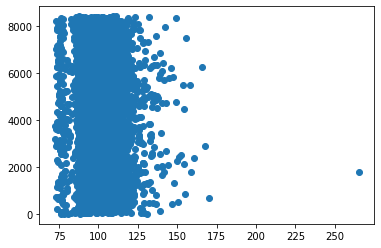

In [3]:
plt.scatter(mercedes_df['y'], mercedes_df['ID'])

In [11]:
mercedes_df=mercedes_df[mercedes_df['y']<150]

In [12]:
missing_values_df=pd.DataFrame({
    'cloumn_name':mercedes_df.columns,
    'missing_count':mercedes_df.isnull().sum(),
    'missing_value_%':mercedes_df.isnull().sum()/mercedes_df.shape[0]*100
})
#missing_values_df.sort_values(by='missing_value_%',ascending=False)

In [13]:
y=mercedes_df.iloc[:,1]
y=np.log(y)

In [14]:
X = mercedes_df.iloc[:, 2:]
X.shape

(4194, 376)

In [15]:
cols_drop=[]

for col in X.columns:
    if X[col].nunique()==X.shape[0] or X[col].nunique()==1:
        cols_drop.append(col)
        X.drop(columns=col, inplace=True)
print(len(cols_drop))
X.shape

13


(4194, 363)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3355 entries, 2745 to 863
Columns: 363 entries, X0 to X385
dtypes: int64(355), object(8)
memory usage: 9.3+ MB


In [17]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)
    
le=LabelEncoderExt()

for col in X_train.columns:
    if X_train[col].dtype=='object':
        le.fit(X_train[col])
        X_train[col]=le.transform(X_train[col])
        X_test[col]=le.transform(X_test[col])

In [18]:
#PCA
pca=PCA()
X_train_pca_df=pd.DataFrame(pca.fit_transform(X_train))

#pca.explained_variance_ratio_#by default it is in decreasing order

Text(0, 0.5, 'Explained veriance ratio')

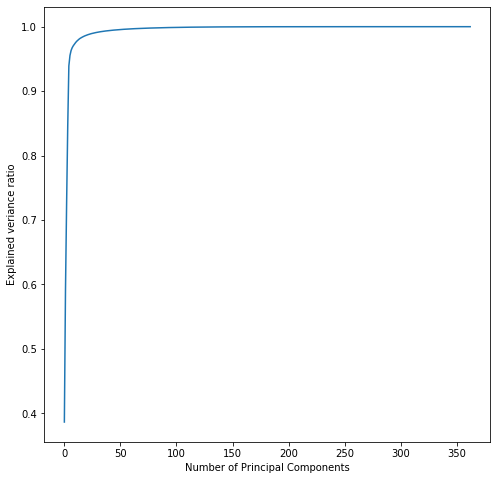

In [40]:
plt.figure(figsize=(8,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained veriance ratio")


In [19]:
pca1 = PCA(n_components=45)
X_train_pca_df = pd.DataFrame(pca1.fit_transform(X_train), columns=list(range(0,45)))
X_test_pca_df =  pd.DataFrame(pca1.transform(X_test))

In [20]:
X_train_pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,-1.544289,-0.824992,2.843841,-2.544883,1.313584,-4.510989,1.497924,-1.848113,2.373873,-0.227971,-1.036275,-0.539819,-0.364791,-0.873234,1.028271,0.284250,0.087535,0.058733,0.664031,-1.168386,-0.508829,0.590414,-0.746548,-0.419586,0.270346,0.159327,-0.097584,0.131015,0.327636,0.172926,0.269879,0.547658,-0.143616,-0.077515,-0.212644,-0.019858,-0.049473,-0.184009,-0.226855,-0.180927,-0.068320,0.135709,0.032409,-0.055209,0.234126
1,-9.959137,2.312521,-5.690243,16.131003,-4.432750,-2.355228,-0.752267,-2.927850,-0.955589,0.079541,-0.124050,0.271745,-0.429917,-0.377628,0.436771,0.157324,-0.940005,0.660553,0.522868,-0.390994,0.716241,-0.990446,0.508297,-0.129431,0.259507,-0.515533,-0.065383,-0.266527,-0.046385,-0.257940,0.103083,-0.291695,-0.314269,-0.067524,0.405480,0.074450,0.368322,-0.033768,-0.304901,-0.022537,-0.112632,0.130355,0.065607,0.137011,0.116226
2,2.638594,-1.888735,6.522407,-14.471979,-7.173325,-2.281573,0.788575,-1.923893,1.651098,-0.561466,-0.534814,0.374972,-1.352883,0.309155,-0.471496,0.084396,-0.212429,-0.024047,-0.304478,0.294221,1.087248,-0.627109,0.396787,0.138117,-0.195273,-0.538636,0.738193,0.301050,-0.493639,-0.883594,0.137393,-0.190730,0.123261,0.202526,0.150256,-0.350714,-0.225407,0.392292,0.138637,-0.177242,-0.191377,0.230836,0.023830,-0.165797,-0.295334
3,28.545711,14.048909,-5.890521,8.691848,-2.105240,-2.068995,1.128292,-0.324627,-0.761758,-0.789632,1.633666,-0.576225,1.355754,-0.549369,1.015327,2.146630,-0.432287,-0.589077,-0.127214,0.449546,0.198616,-0.624624,-0.060750,0.319459,0.765583,-0.513115,0.045952,0.232231,-0.244286,0.224951,-0.061547,0.478726,0.181395,-0.377737,-0.490816,-0.062465,-0.098364,0.088359,0.445133,0.150082,0.124207,-0.211369,0.006715,0.244105,-0.585212
4,-2.263481,-8.139869,11.287388,4.394998,-12.202797,0.357330,-2.664678,0.129632,-0.518654,-0.660245,0.054001,-0.402660,0.600628,-0.142739,1.218801,0.477337,-0.552997,0.146693,0.300694,0.316413,-0.651149,-1.395147,-0.994150,0.009017,-0.860938,-0.113742,0.545029,-0.164758,-0.668395,-0.389105,0.251451,0.914531,0.176540,-0.149310,-0.149043,-0.313318,0.048973,-0.584387,0.145278,-0.228382,-0.059748,0.237914,-0.277846,0.502227,0.132296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350,-14.219149,-6.974966,4.092569,-10.268049,-7.130547,0.910125,-2.759280,1.676623,-1.895374,1.155819,1.379139,-0.230293,-1.285764,-1.476814,1.656293,0.186880,0.310852,0.439531,0.061626,-0.920937,0.296203,0.566254,-0.369008,-0.128690,-0.068601,-0.224132,0.179661,-0.321636,0.291466,-0.189636,-0.446249,0.074973,0.111538,0.166842,0.192033,-0.452788,-0.068857,0.205273,0.272273,-0.102809,-0.067893,-0.284417,0.143581,-0.110138,-0.052485
3351,0.552702,16.452711,0.200888,9.764205,-10.341630,-4.134721,1.136563,0.721318,-1.382319,-1.017499,0.900494,-0.738191,0.557064,0.835164,-0.345780,-0.541781,0.097288,0.850518,0.717570,0.664378,0.485552,0.493027,-0.655081,-1.136077,-0.988839,0.346736,-0.365619,0.324004,-0.859652,-0.112508,0.557931,-0.157967,0.404897,0.333191,0.189529,-0.287762,-0.177926,-0.305335,-0.089031,0.619654,0.231737,-0.036520,0.325149,0.044162,-0.080211
3352,-9.193261,1.516230,13.556272,9.754312,-2.245289,-1.547189,1.431038,-1.824192,-1.683108,1.508862,-0.261287,0.912091,-1.048905,0.129091,-0.224614,-0.201466,-0.798110,0.618364,1.719355,1.389720,-0.082800,-0.321606,0.940902,0.510068,-0.628191,-0.093034,-0.783109,0.015262,0.697227,0.389809,0.465626,0.231340,-0.343397,0.137666,-0.473930,0.552502,0.092304,0.438345,0.249907,-0.725016,-0.161702,0.115188,-0.631952,-0.416700,-0.249932
3353,-14.002240,11.481141,10.546388,-5.651545,-2.751973,-1.785202,-1.588163,-0.468043,-0.513397,-0.286634,-0.127733,0.417867,0.319218,-1.601648,-0.355809,0.949766,1.321265,-0.466270,0.004640,0.215675,-0.126002,-0.929815,1.17075

In [21]:
columns = []
print ("columns","\t", "PearSon Coree","\t\t", "pvalue","\n")
for col in X_train_pca_df.columns:
    corre, pvalue = stats.pearsonr(X_train_pca_df[col], y_train)
    
    if (pvalue < 0.03):
        print (col,"\t", corre*100,"\t", pvalue)
        columns.append(col)
print("\n No of PCAs Highly Correlate with Target Veriable: ==>:", len(columns), "Outof_Available PCAs",X_train_pca_df.shape[1])

columns 	 PearSon Coree 		 pvalue 

0 	 19.476964092350336 	 4.8807611126883136e-30
2 	 -7.230613378030369 	 2.7642176841118125e-05
3 	 -8.093504631001862 	 2.680400243448609e-06
6 	 18.344086735611597 	 8.903178944562297e-27
7 	 -34.57372783727798 	 8.127065386922516e-95
9 	 31.093069899407567 	 4.1257682580382434e-76
10 	 -11.316125304138032 	 4.922949840070088e-11
11 	 -29.87690151813034 	 3.845361583790711e-70
12 	 11.941209221673187 	 3.951839621596043e-12
13 	 -16.01179736621214 	 1.0466113111585193e-20
14 	 3.7531984695333658 	 0.029712871826822224
15 	 14.895946630185728 	 4.197813536968449e-18
16 	 -33.094046662601805 	 1.4521562854757674e-86
17 	 6.316568946996373 	 0.00025123409159330355
19 	 3.94080895897767 	 0.02245124745304944
20 	 6.755336060677536 	 9.008040557945646e-05
21 	 6.286909987981766 	 0.0002686687859802547
22 	 6.445252825099186 	 0.00018716695916021252
24 	 -3.9746810884929524 	 0.021319331326801663
25 	 4.494765531211452 	 0.00921911288482364
32 	 -8.99046

In [22]:
X_train_pca_df_final = X_train_pca_df[columns]
X_test_pca_df_final = X_test_pca_df[columns]

In [23]:
mms = MinMaxScaler()

for col in X_test_pca_df_final.columns:
    X_train_pca_df_final[col] = mms.fit_transform(np.array(X_train_pca_df_final[col]).reshape(-1,1))
    X_test_pca_df_final[col] = mms.transform(np.array(X_test_pca_df_final[col]).reshape(-1,1))

In [41]:
def model_Execute(xtrain, xtest, ytrain, ytest, model):
    obj = model
    obj.fit(xtrain, ytrain)
    y_predict = obj.predict(xtest)
    y_predict_train = obj.predict(xtrain)
    
    test_r2_score = r2_score(ytest, y_predict)
    train_r2_score = r2_score(ytrain, y_predict_train)
    print(str(obj).split("(")[0])
    print("Train Accuracy(R2 Score): ===========>", train_r2_score)
    print("Test Accuracuy(R2 Score): ===========>", test_r2_score)
    print("MeanSquareError: ====================>", mean_squared_error(ytest, y_predict))
    print("RootMeanSquareError: ================>", np.sqrt(mean_squared_error(ytest, y_predict)), "\n")

In [42]:
models = {
    'lr': LinearRegression(),
    'dt': DecisionTreeRegressor(),
    'rf': RandomForestRegressor(),
    'agb': AdaBoostRegressor(),
    'gbr': GradientBoostingRegressor()
}

In [43]:
for mName, Model in models.items():
    model_Execute(X_train_pca_df_final, X_test_pca_df_final, y_train, y_test, Model)

LinearRegression
Train Accuracy(R2 Score): ===========> 0.6045571089259559
Test Accuracuy(R2 Score): ===========> 0.6338208725002121
MeanSquareError: ====================> 0.005346681039446841
RootMeanSquareError: ================> 0.07312100272457182 

DecisionTreeRegressor
Train Accuracy(R2 Score): ===========> 0.977555485923921
Test Accuracuy(R2 Score): ===========> 0.3428675759215123
MeanSquareError: ====================> 0.009594969260579242
RootMeanSquareError: ================> 0.09795391396253261 

RandomForestRegressor
Train Accuracy(R2 Score): ===========> 0.9225477583253731
Test Accuracuy(R2 Score): ===========> 0.6069128682200342
MeanSquareError: ====================> 0.005739572128779249
RootMeanSquareError: ================> 0.07575996389108992 

AdaBoostRegressor
Train Accuracy(R2 Score): ===========> 0.39026222703366054
Test Accuracuy(R2 Score): ===========> 0.3958639174572708
MeanSquareError: ====================> 0.008821155263085752
RootMeanSquareError: =============

In [27]:
adbR = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=2020)

In [28]:
adbR_params = {
    'n_estimators': np.arange(5, 200, 5),
    'learning_rate': np.linspace(0.0001, 1, 15),
    'loss': ['linear', 'square', 'exponential'],
    "base_estimator__criterion" : ["friedman_mse", "mse"],
    "base_estimator__min_samples_split": np.arange(1, 20, 1),
    "base_estimator__min_samples_leaf": np.arange(1, 20, 1),
    "base_estimator__max_depth" : np.arange(1, 20, 1)
}

In [29]:
rsCV = RandomizedSearchCV(estimator=adbR, param_distributions=adbR_params, scoring='r2', n_jobs=-1, n_iter=200)

In [30]:
rsCV.fit(X_train_pca_df_final, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                    criterion='mse',
                                                                                    max_depth=None,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                  

In [31]:
best_model = rsCV.best_estimator_

In [32]:
best_model.fit(X_train_pca_df_final, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=11,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=3,
                                                       min_samples_split=14,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                

In [33]:
model_Execute(X_train_pca_df_final, X_test_pca_df_final, y_train, y_test, best_model)

AdaBoostRegressor
Train Accuracy(R2 Score): ===========> 0.8232381117775716
Test Accuracuy(R2 Score): ===========> 0.6290172350027212
MeanSquareError: ====================> 0.005416820257112178
RootMeanSquareError: ================> 0.07359905065360679 



In [34]:
gbR_hyp = GradientBoostingRegressor(random_state=42)
gbr_params = {
    'learning_rate': [0.001, 0.01, 0.1],
    'loss': ['ls', 'lad', 'huber'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': np.arange(1, 8),
    'n_estimators': [5, 10, 15, 20],
    'tol': [0.0001, 0.001, 0.01, 0.1]
}

score = make_scorer(r2_score)

In [35]:
gbr_rsCV = RandomizedSearchCV(gbR_hyp, param_distributions=gbr_params, scoring=score, random_state=42)

In [36]:
gbr_rsCV.fit(X_train_pca_df_final, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                          

In [37]:
gbr_hyp_best = gbr_rsCV.best_estimator_

In [38]:
gbr_hyp_best.fit(X_train_pca_df_final, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
model_Execute(X_train_pca_df_final, X_test_pca_df_final, y_train, y_test, gbr_hyp_best)

GradientBoostingRegressor
Train Accuracy(R2 Score): ===========> 0.5416350397706708
Test Accuracuy(R2 Score): ===========> 0.5747885375689474
MeanSquareError: ====================> 0.006208628218266997
RootMeanSquareError: ================> 0.07879484893231915 

